# Language detection using neural networks

### Imports

In [1]:
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

### Check GPU availability

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Data loading

In [3]:
df = pd.read_csv("data/sentences_10k.csv", delimiter=",", encoding='utf8', index_col=0)
df.head()

,id,lan_code,sentence
0,1,cmn,我們試試看！
1,2,cmn,我该去睡觉了。
2,3,cmn,你在干什麼啊？
3,4,cmn,這是什麼啊？
4,5,cmn,今天是６月１８号，也是Muiriel的生日！


In [4]:
langs = list(df["lan_code"].unique())

In [5]:
lang_to_num = {lan: i for i, lan in enumerate(langs)}
print(lang_to_num)

num_to_lang = {i: lan for lan, i in lang_to_num.items()}
print(num_to_lang)

{'cmn': 0, 'deu': 1, 'rus': 2, 'fra': 3, 'eng': 4, 'jpn': 5, 'spa': 6, 'ita': 7, 'vie': 8, 'nld': 9, 'epo': 10, 'por': 11, 'tur': 12, 'heb': 13, 'hun': 14, 'ell': 15, 'ind': 16, 'ara': 17, 'fin': 18, 'bul': 19, 'swe': 20, 'ukr': 21, 'bel': 22, 'ces': 23, 'nob': 24, 'pol': 25, 'lat': 26, 'isl': 27, 'ron': 28, 'tat': 29, 'srp': 30, 'dan': 31, 'pes': 32, 'slk': 33, 'tgl': 34, 'hin': 35, 'lit': 36, 'mkd': 37, 'jbo': 38, 'tok': 39, 'ina': 40, 'nds': 41, 'tlh': 42, 'kab': 43, 'ber': 44, 'mar': 45, 'ckb': 46, 'lfn': 47}
{0: 'cmn', 1: 'deu', 2: 'rus', 3: 'fra', 4: 'eng', 5: 'jpn', 6: 'spa', 7: 'ita', 8: 'vie', 9: 'nld', 10: 'epo', 11: 'por', 12: 'tur', 13: 'heb', 14: 'hun', 15: 'ell', 16: 'ind', 17: 'ara', 18: 'fin', 19: 'bul', 20: 'swe', 21: 'ukr', 22: 'bel', 23: 'ces', 24: 'nob', 25: 'pol', 26: 'lat', 27: 'isl', 28: 'ron', 29: 'tat', 30: 'srp', 31: 'dan', 32: 'pes', 33: 'slk', 34: 'tgl', 35: 'hin', 36: 'lit', 37: 'mkd', 38: 'jbo', 39: 'tok', 40: 'ina', 41: 'nds', 42: 'tlh', 43: 'kab', 44: 'b

In [6]:
df["lang_num"] = df["lan_code"].map(lang_to_num).astype(int)
lang_count = len(df['lang_num'].unique())

In [7]:
mean_sentence_len = df["sentence"].str.len().mean()
median_sentence_len = df["sentence"].str.len().median()

print(f"Mean length of sentence: {mean_sentence_len}")
print(f"Median length of sentence: {median_sentence_len}")

Mean length of sentence: 35.63898586965506
Median length of sentence: 31.0


In [8]:
input_length = int(np.floor(max(mean_sentence_len, median_sentence_len)))
print(f"Input length: {input_length}")

Input length: 35


In [9]:
def sentence_to_unicode_list(sentence):
    max_len = input_length
    unicode_list = [ord(i) for i in sentence]
    
    if len(unicode_list) >= max_len:
        unicode_list = unicode_list[:max_len]
    else:
        len_diff = max_len - len(unicode_list)
        unicode_list.extend([0 for _ in range(len_diff)])
    
    return unicode_list

def set_labels(lang):
    labels = [0 for _ in range(lang_count)]
    labels[lang] = 1
    return labels

In [10]:
df['unicode'] = df['sentence'].apply(sentence_to_unicode_list)
df['labels'] = df['lang_num'].apply(set_labels)

In [11]:
df.dropna()
df.sample(10)

,id,lan_code,sentence,lang_num,unicode,labels
2989422,3171541,eng,Tom forced Mary to sign the contract.,4,"[84, 111, 109, 32, 102, 111, 114, 99, 101, 100...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6050351,6429178,eng,Mary reached for her hat.,4,"[77, 97, 114, 121, 32, 114, 101, 97, 99, 104, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
353337,369304,bul,"Когато заспиваш, изведнъж някакъв звук отеква ...",19,"[1050, 1086, 1075, 1072, 1090, 1086, 32, 1079,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7901841,8316760,kab,Win ik-yennan teshel lɣerba ad d-yas ad iyi-d-...,43,"[87, 105, 110, 32, 105, 107, 45, 121, 101, 110...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4227190,4501417,eng,The way they plan to punish Tom seems kind of ...,4,"[84, 104, 101, 32, 119, 97, 121, 32, 116, 104,...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
762734,799264,nds,Wat snackst du för ’n Tüdelkraam?,41,"[87, 97, 116, 32, 115, 110, 97, 99, 107, 115, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1950244,2064711,eng,We got something from Tom.,4,"[87, 101, 32, 103, 111, 116, 32, 115, 111, 109...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1044299,1096125,eng,Neither Tom nor Mary was in a talkative mood.,4,"[78, 101, 105, 116, 104, 101, 114, 32, 84, 111...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
459624,480071,epo,Vi vidis nenion.,10,"[86, 105, 32, 118, 105, 100, 105, 115, 32, 110...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
8454903,8886129,hun,Ezt a lovat képtelenség megzabolázni.,14,"[69, 122, 116, 32, 97, 32, 108, 111, 118, 97, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [12]:
df_numpy = df.to_numpy()

### Dense net

In [13]:
x = np.array(list(df_numpy[:, -2])[:-1])
y = np.array(list(df_numpy[:, -1])[:-1])

print(f"x_shape: {x.shape}")
print(f"y_shape: {y.shape}")

x_shape: (10041509, 35)
y_shape: (10041509, 48)


In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True)

In [15]:
x_train.shape

(7029056, 35)

In [61]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', kernel_regularizer='l1_l2', input_shape=(input_length,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu', kernel_regularizer='l1_l2'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu', kernel_regularizer='l1_l2'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation='relu', kernel_regularizer='l1_l2'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1024, activation='relu', kernel_regularizer='l1_l2'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu', kernel_regularizer='l1_l2'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(lang_count, activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 128)               4608      
                                                                 
 dropout_62 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 256)               33024     
                                                                 
 dropout_63 (Dropout)        (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 512)               131584    
                                                                 
 dropout_64 (Dropout)        (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 1024)             

In [62]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.CategoricalCrossentropy()

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [63]:
batch_size = 1024
epochs = 30

hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/30
6865/6865 [==============================] - 57s 8ms/step - loss: 146.2057 - accuracy: 0.2082 - val_loss: 3.6351 - val_accuracy: 0.2738
Epoch 2/30
6865/6865 [==============================] - 55s 8ms/step - loss: 3.0536 - accuracy: 0.2694 - val_loss: 2.8943 - val_accuracy: 0.2782
Epoch 3/30
6865/6865 [==============================] - 55s 8ms/step - loss: 2.9393 - accuracy: 0.2734 - val_loss: 2.8808 - val_accuracy: 0.2842
Epoch 4/30
6865/6865 [==============================] - 53s 8ms/step - loss: 2.9260 - accuracy: 0.2754 - val_loss: 2.8748 - val_accuracy: 0.2862
Epoch 5/30
6865/6865 [==============================] - 54s 8ms/step - loss: 2.9177 - accuracy: 0.2767 - val_loss: 2.8715 - val_accuracy: 0.2868
Epoch 6/30
6865/6865 [==============================] - 54s 8ms/step - loss: 2.9103 - accuracy: 0.2775 - val_loss: 2.8605 - val_accuracy: 0.2880
Epoch 7/30
6865/6865 [==============================] - 55s 8ms/step - loss: 2.9039 - accuracy: 0.2784 - val_loss: 2.8632 - val_

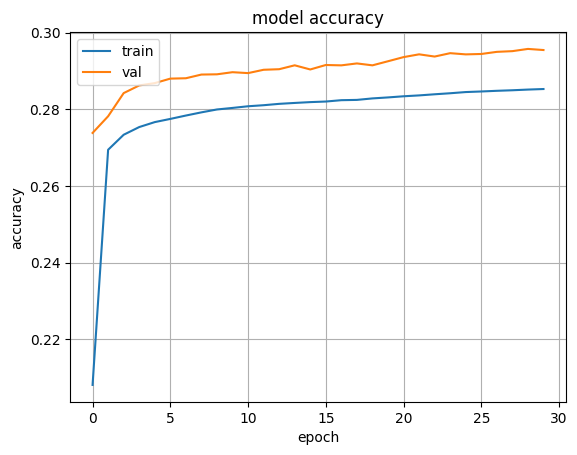

In [64]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

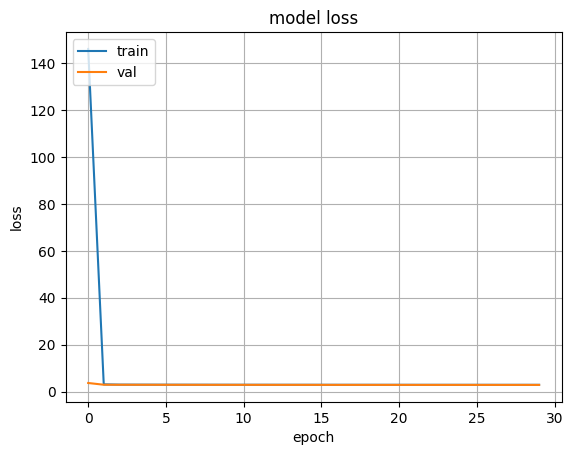

In [65]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [66]:
save_path = 'models/'
model.save_weights(save_path + 'dense_network.h5')

### Conv1D net

In [14]:
model_conv = models.Sequential()
model_conv.add(layers.Conv1D(32, 1, activation='relu', kernel_regularizer='l1_l2', input_shape=(input_length, 1)))
model_conv.add(layers.Dropout(0.1))
model_conv.add(layers.Conv1D(64, 1, activation='relu', kernel_regularizer='l1_l2'))
model_conv.add(layers.Dropout(0.15))
model_conv.add(layers.Conv1D(64, 1, activation='relu', kernel_regularizer='l1_l2'))
model_conv.add(layers.Dropout(0.2))
model_conv.add(layers.Conv1D(128, 1, activation='relu', kernel_regularizer='l1_l2'))
model_conv.add(layers.Dropout(0.2))
model_conv.add(layers.Conv1D(128, 1, activation='relu', kernel_regularizer='l1_l2'))
model_conv.add(layers.Dropout(0.25))
model_conv.add(layers.Conv1D(256, 1, activation='relu', kernel_regularizer='l1_l2'))
model_conv.add(layers.Dropout(0.3))
model_conv.add(layers.Conv1D(256, 1, activation='relu', kernel_regularizer='l1_l2'))
model_conv.add(layers.Dropout(0.3))
model_conv.add(layers.Flatten())
model_conv.add(layers.Dense(1024, activation='relu', kernel_regularizer='l1_l2'))
model_conv.add(layers.Dropout(0.3))
model_conv.add(layers.Dense(lang_count, activation='softmax'))

model_conv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 35, 32)            64        
                                                                 
 dropout (Dropout)           (None, 35, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 35, 64)            2112      
                                                                 
 dropout_1 (Dropout)         (None, 35, 64)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 35, 64)            4160      
                                                                 
 dropout_2 (Dropout)         (None, 35, 64)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 35, 128)           8

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.CategoricalCrossentropy()

model_conv.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [16]:
x_conv = np.expand_dims(np.array(list(df_numpy[:, -2])[:-1]), axis=2)
y_conv = np.array(list(df_numpy[:, -1])[:-1])

print(f"x_shape: {x_conv.shape}")
print(f"y_shape: {y_conv.shape}")

x_shape: (10041509, 35, 1)
y_shape: (10041509, 48)


In [17]:
x_train_conv, x_test_conv, y_train_conv, y_test_conv = train_test_split(x, y, test_size=0.3, shuffle=True)

In [18]:
batch_size_conv = 1024
epochs_conv = 20

hist_conv = model_conv.fit(x_train_conv, y_train_conv, batch_size=batch_size_conv, epochs=epochs_conv, validation_data=(x_test_conv, y_test_conv))

Epoch 1/20
6865/6865 [==============================] - 326s 46ms/step - loss: 19.3395 - accuracy: 0.3008 - val_loss: 12.5564 - val_accuracy: 0.3199
Epoch 2/20
6865/6865 [==============================] - 317s 46ms/step - loss: 12.7513 - accuracy: 0.3297 - val_loss: 12.7861 - val_accuracy: 0.3418
Epoch 3/20
6865/6865 [==============================] - 317s 46ms/step - loss: 12.8495 - accuracy: 0.3397 - val_loss: 12.7729 - val_accuracy: 0.3555
Epoch 4/20
6865/6865 [==============================] - 317s 46ms/step - loss: 12.9070 - accuracy: 0.3431 - val_loss: 12.8092 - val_accuracy: 0.3577
Epoch 5/20
6865/6865 [==============================] - 317s 46ms/step - loss: 12.9301 - accuracy: 0.3444 - val_loss: 12.8471 - val_accuracy: 0.3559
Epoch 6/20
6865/6865 [==============================] - 317s 46ms/step - loss: 12.9431 - accuracy: 0.3459 - val_loss: 12.8613 - val_accuracy: 0.3588
Epoch 7/20
6865/6865 [==============================] - 317s 46ms/step - loss: 12.9562 - accuracy: 0.3471 

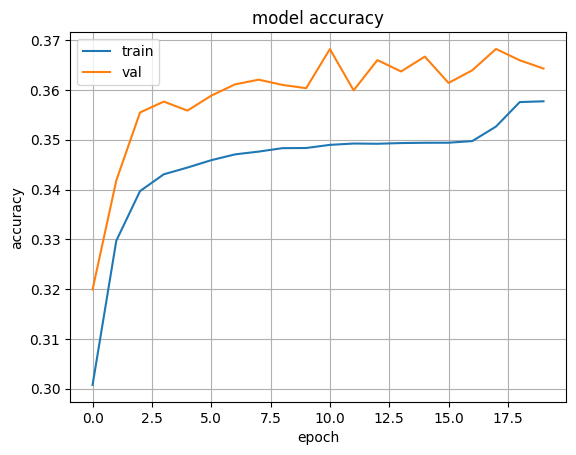

In [19]:
plt.plot(hist_conv.history['accuracy'])
plt.plot(hist_conv.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

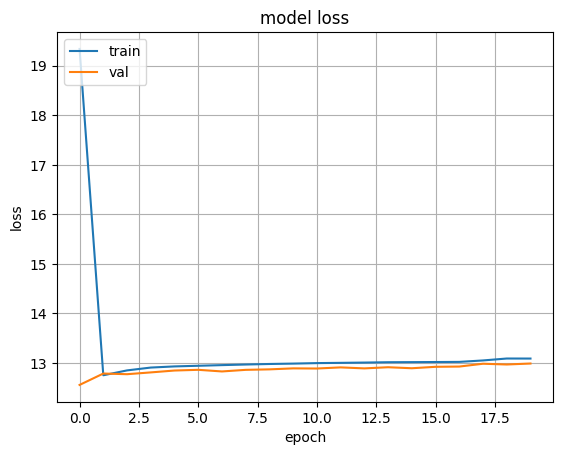

In [20]:
plt.plot(hist_conv.history['loss'])
plt.plot(hist_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [22]:
save_path = 'models/'
model_conv.save_weights(save_path + 'conv1d_network.h5')

### LSTM network

In [37]:
print(f"x_shape: {x.shape}")
print(f"y_shape: {y.shape}")

1000 1000


In [38]:
x_train_rec, x_test_rec, y_train_rec, y_test_rec = train_test_split(x, y, test_size=0.9, shuffle=True)

In [34]:
model_rec = models.Sequential()

model_rec.add(layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(128, return_sequences=True), input_shape=(input_length,)))
model_rec.add(layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(64)))
model_rec.add(layers.Dense(lang_count, activation='softmax'))

model_rec.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_18 (Bidirecti  (None, 1, 128)           48128     
 onal)                                                           
                                                                 
 bidirectional_19 (Bidirecti  (None, 48)               29376     
 onal)                                                           
                                                                 
 dense_11 (Dense)            (None, 24)                1176      
                                                                 
Total params: 78,680
Trainable params: 78,680
Non-trainable params: 0
_________________________________________________________________


In [35]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.CategoricalCrossentropy()

model_conv.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [39]:
batch_size = 64
epochs = 30

hist_rec = model_rec.fit(x_train_rec, y_train_rec, batch_size=batch_size, epochs=epochs, validation_data=(x_test_rec, y_test_rec))

Epoch 1/30


: 

: 

In [ ]:
plt.plot(hist_rec.history['accuracy'])
plt.plot(hist_rec.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
plt.plot(hist_rec.history['loss'])
plt.plot(hist_rec.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
model_rec.save_weights(save_path + 'lstm_network.h5')